In [1]:
import numpy as np
import pandas as pd
import mne
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample, savgol_filter

from source.data_loader import load_eeg_data, open_json_file, select_recording, read_time_domain_data, compute_eeg_power

from source.sync_peaks_finder import find_eeg_peak, find_dbs_peak, detect_eeg_drop_onset_window

In [2]:
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009']

block = 'pre8walk' # 'baseline', 'treadmill'

dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"


Function for EEG Power Calculation

In [3]:
# # loop through subjects

# for sub_id in sub_ids:

#     print(f"---\nProcessing subject {sub_id} for block {block}...")
#     eeglab_file_path_components = [dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set']
#     eeglab_file_path = os.path.join(*eeglab_file_path_components)
#     # check if the file exists, if not, skip the subject
#     if not os.path.exists(eeglab_file_path):
#         print(f"---\nSkipping subject {sub_id} for block {block} as the file {eeglab_file_path} does not exist.")
#         continue
#     #  Load the EEG data
#     raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)

#     # if subject is not P4-2006, use the default frequency range
#     if sub_id == 'P4-2007':
#         freq_low, freq_high = 110, 120
#     else:   
#         freq_low, freq_high = 120, 130

#     eeg_peak_idx, eeg_peak_time, eeg_power_band_sum = find_eeg_peak(raw, freq_low, freq_high, 
#                                                                     duration_sec=120, save_dir=None)


## EEG drop index detection

In [ ]:
# loop through subjects

for sub_id in sub_ids:

    print(f"---\nProcessing subject {sub_id} for block {block}...")
    eeglab_file_path_components = [dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set']
    eeglab_file_path = os.path.join(*eeglab_file_path_components)
    # check if the file exists, if not, skip the subject
    if not os.path.exists(eeglab_file_path):
        print(f"---\nSkipping subject {sub_id} for block {block} as the file {eeglab_file_path} does not exist.")
        continue
    #  Load the EEG data
    eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
    eeg_fs = eeg_raw.info['sfreq']

    # if subject is not P4-2007, use the default frequency range
    if sub_id == 'P4-2007':
        freq_low, freq_high = 100, 120
        
    else:   
        freq_low, freq_high = 100, 130



    # Get the EEG power for the P0z channel
    channel_name = 'CPz'
    eeg_power, time_axis = compute_eeg_power(eeg_raw, freq_low, freq_high, channel=channel_name, plot=False)
    
    # Get the drop index 
    drop_idx, _, _ = detect_eeg_drop_onset_window(eeg_power, eeg_fs, plot=True)



# Check drop detection for one subject, all channels

In [12]:
# # loop through subjects

# sub_id = 'P4-2005'
# block = 'baseline'

# print(f"---\nProcessing subject {sub_id} for block {block}...")
# eeglab_file_path_components = [dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set']
# eeglab_file_path = os.path.join(*eeglab_file_path_components)
# # check if the file exists, if not, skip the subject
# if not os.path.exists(eeglab_file_path):
#     print(f"---\nSkipping subject {sub_id} for block {block} as the file {eeglab_file_path} does not exist.")
# #  Load the EEG data
# eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
# eeg_fs = eeg_raw.info['sfreq']

# # if subject is not P4-2007, use the default frequency range
# if sub_id == 'P4-2007':
#     freq_low, freq_high = 110, 120
    
# else:   
#     freq_low, freq_high = 120, 130



# # get the channel names of the eeg data
# eeg_channel_names = eeg_raw.ch_names
# for ch in eeg_channel_names:
#     eeg_power, time_axis = compute_eeg_power(eeg_raw, freq_low=120, freq_high=130, channel=ch, plot=True)    

# # Get the drop index 
# # drop_idx, _, _ = detect_eeg_drop_onset_window(eeg_power, eeg_fs, plot=True)


Processing P4-2001...


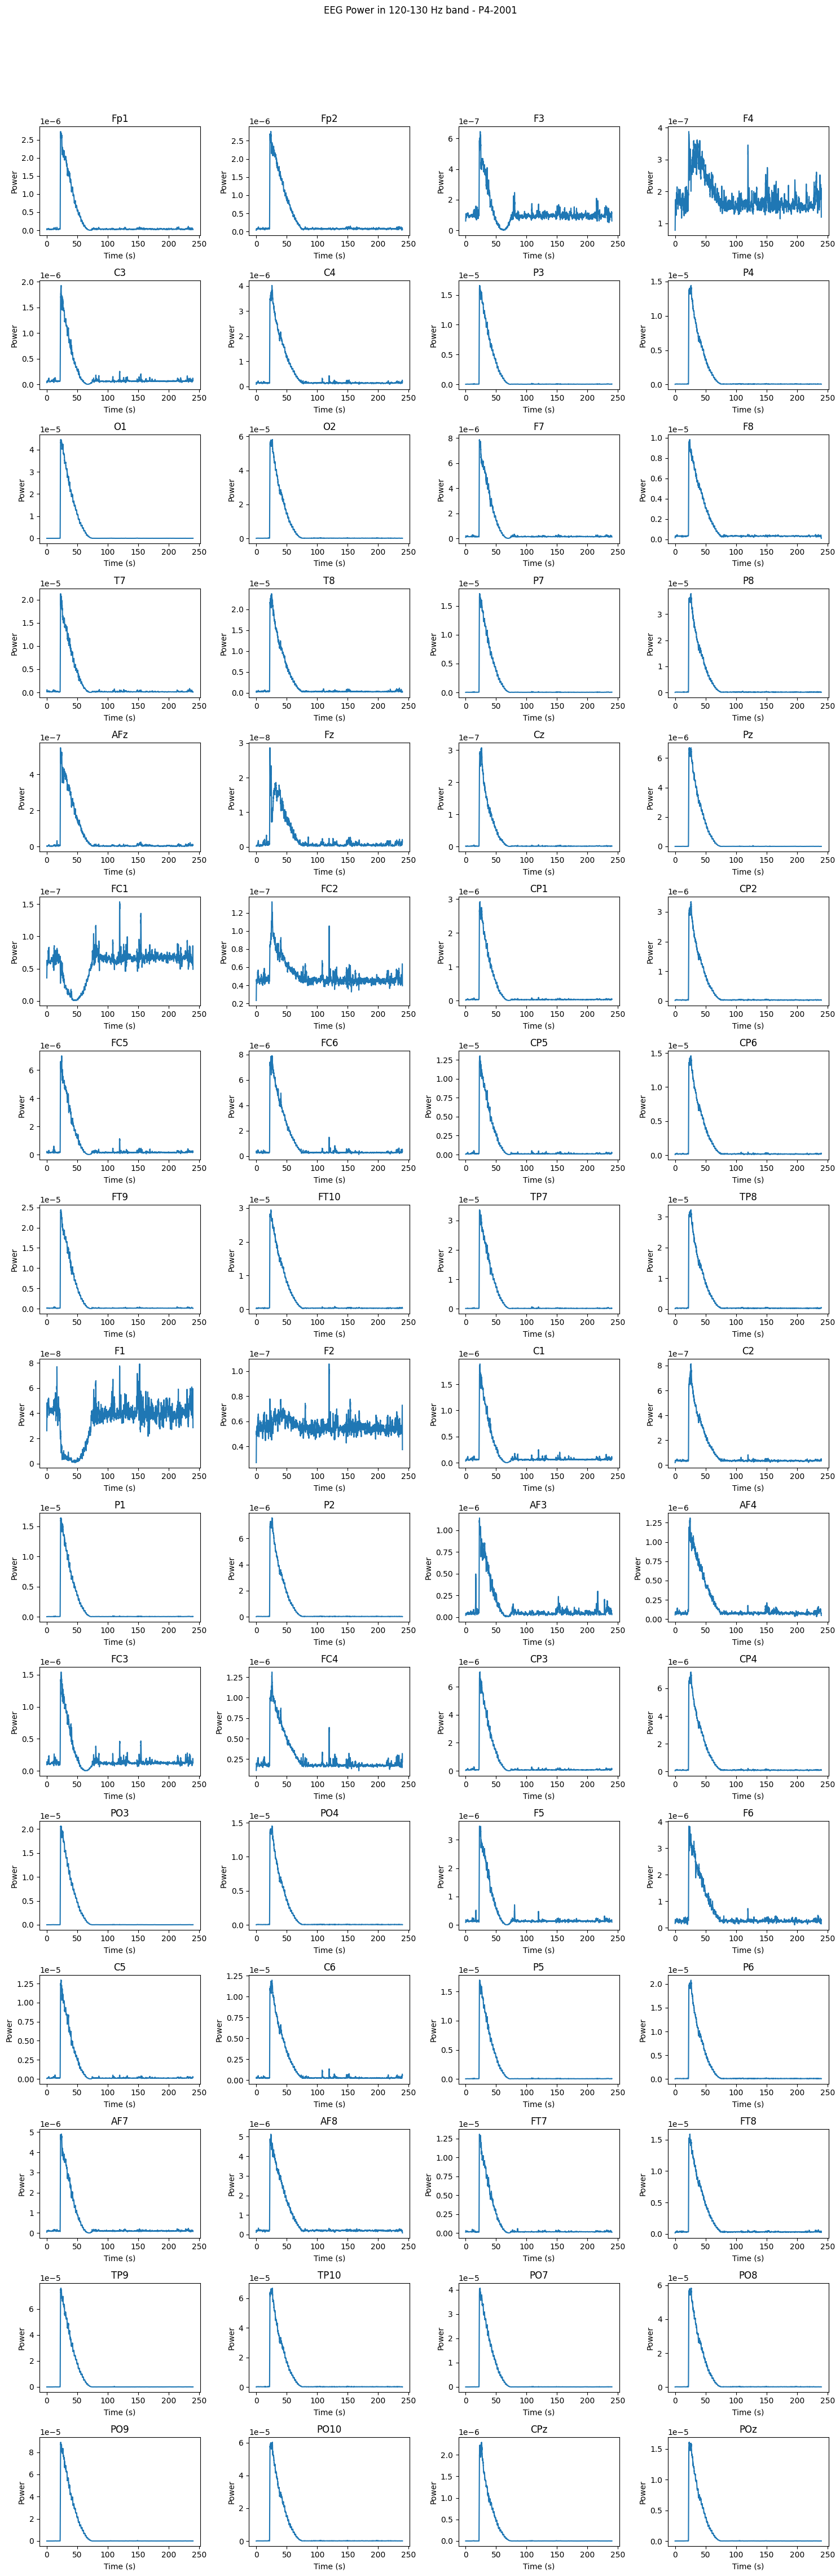

In [15]:
def plot_power_grid(sub_ids, block, dataDir_server):
    for sub_id in sub_ids:
        print(f"\nProcessing {sub_id}...")
        eeglab_file_path = os.path.join(
            dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set'
        )
        if not os.path.exists(eeglab_file_path):
            print(f"Skipping {sub_id}, file not found.")
            continue

        eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
        if sub_id == 'P4-2007':
            freq_low, freq_high = 110, 120
        else:
            freq_low, freq_high = 120, 130

        eeg_channel_names = eeg_raw.ch_names
        n_channels = len(eeg_channel_names)
        n_cols = 4
        n_rows = int(np.ceil(n_channels / n_cols))

        plt.figure(figsize=(15, n_rows * 3))
        for i, ch in enumerate(eeg_channel_names):
            try:
                eeg_power, time_axis = compute_eeg_power(
                    eeg_raw, freq_low, freq_high, channel=ch, duration_sec=240
                )
            except Exception as e:
                print(f"Error processing {ch}: {e}")
                continue
            plt.subplot(n_rows, n_cols, i + 1)
            plt.plot(time_axis, eeg_power)
            plt.title(ch)
            plt.xlabel('Time (s)')
            plt.ylabel('Power')

        plt.suptitle(f"EEG Power in 120-130 Hz band - {sub_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage
sub_ids = [ 'P4-2001']
block = 'pre8walk' # 'baseline', 'treadmill', 'pre8walk'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"
plot_power_grid(sub_ids, block, dataDir_server)


Processing P4-2001...


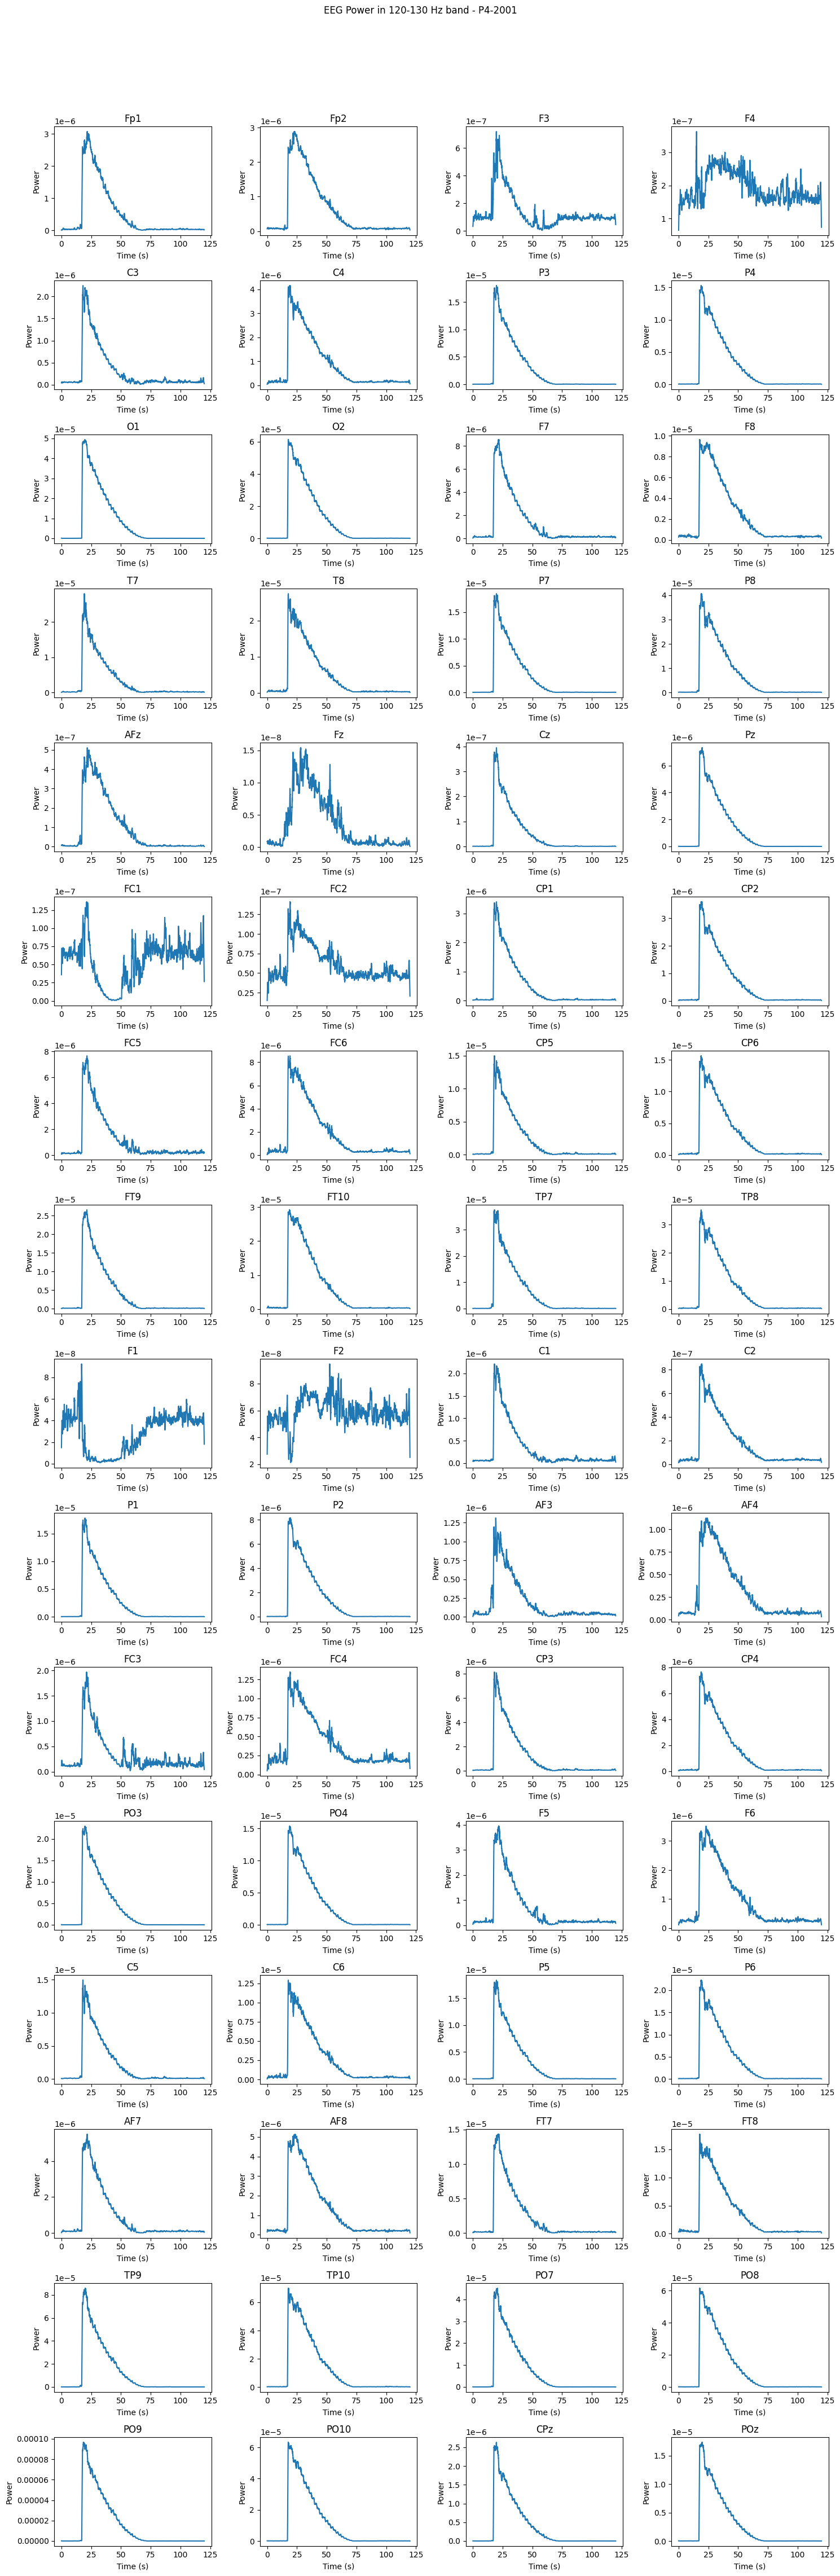


Processing P4-2002...


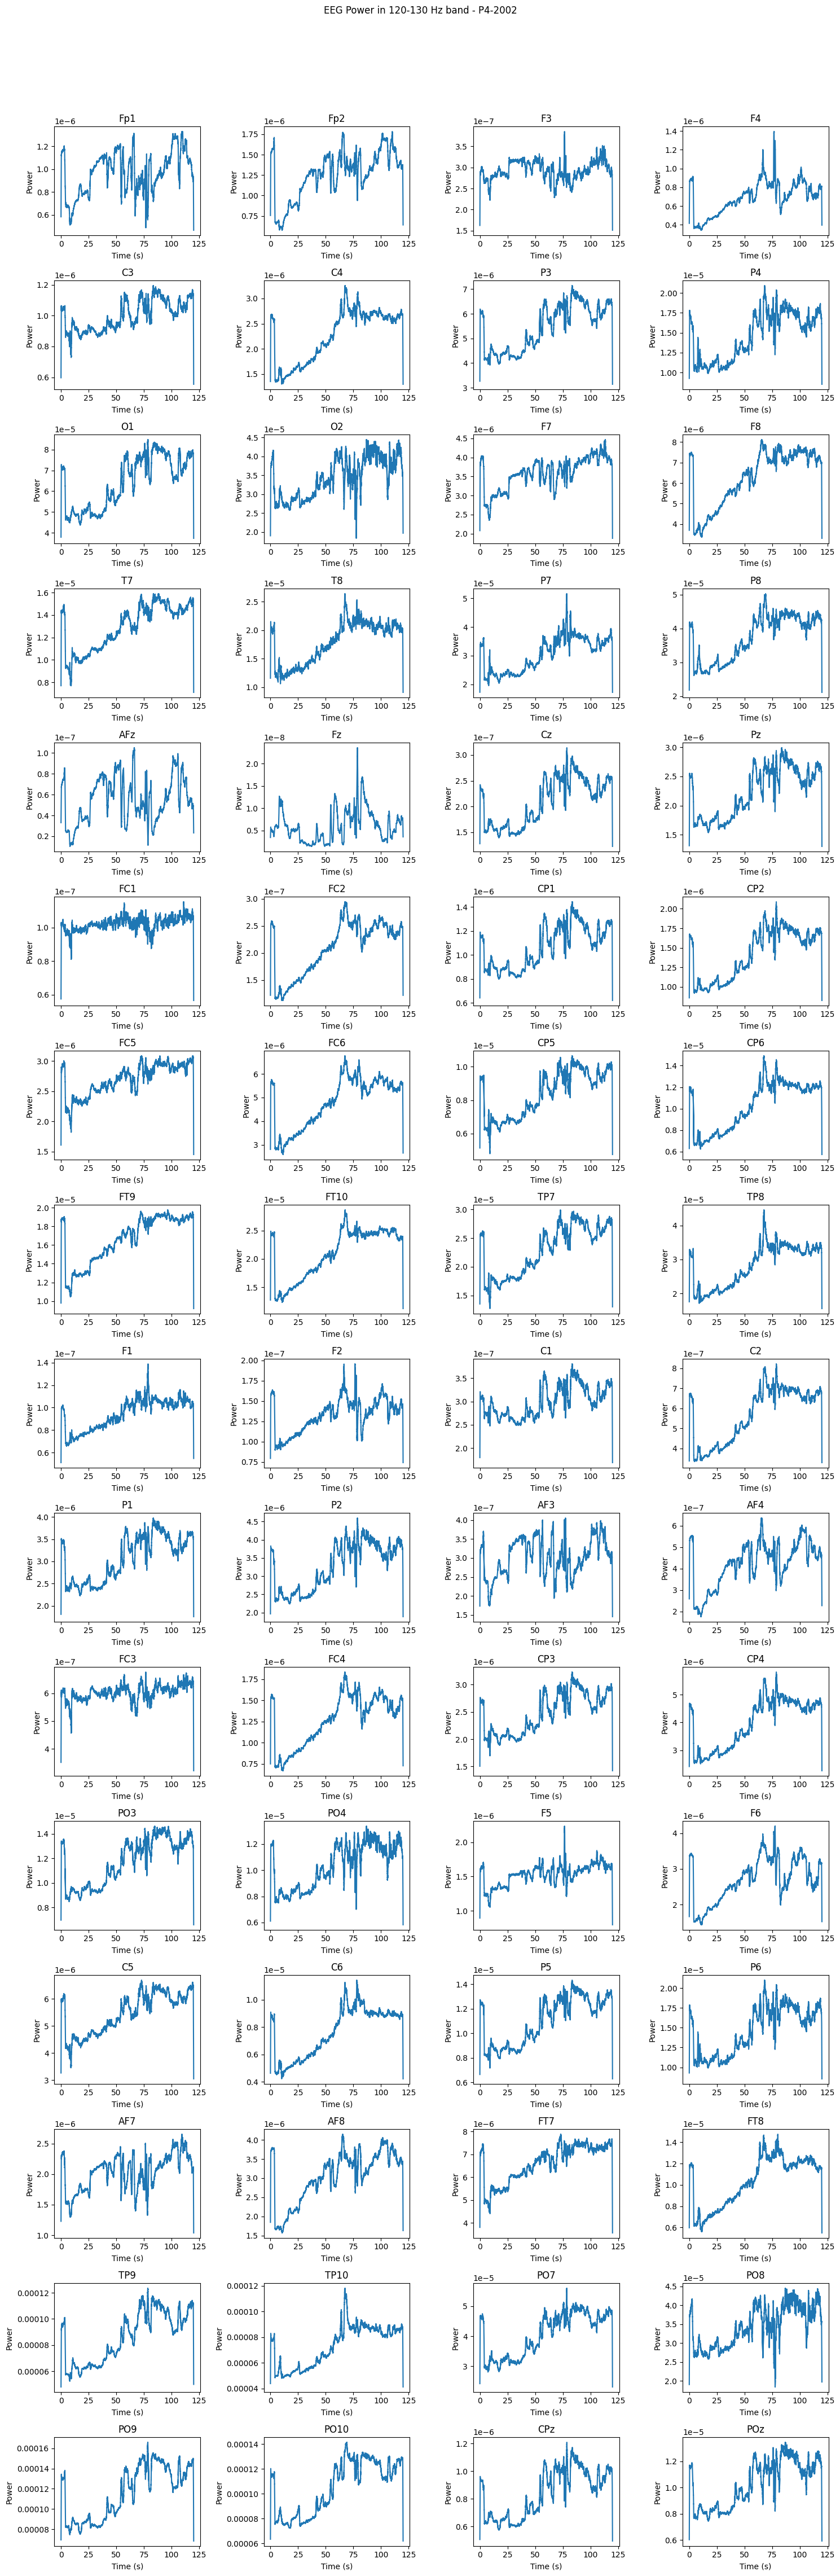


Processing P4-2003...


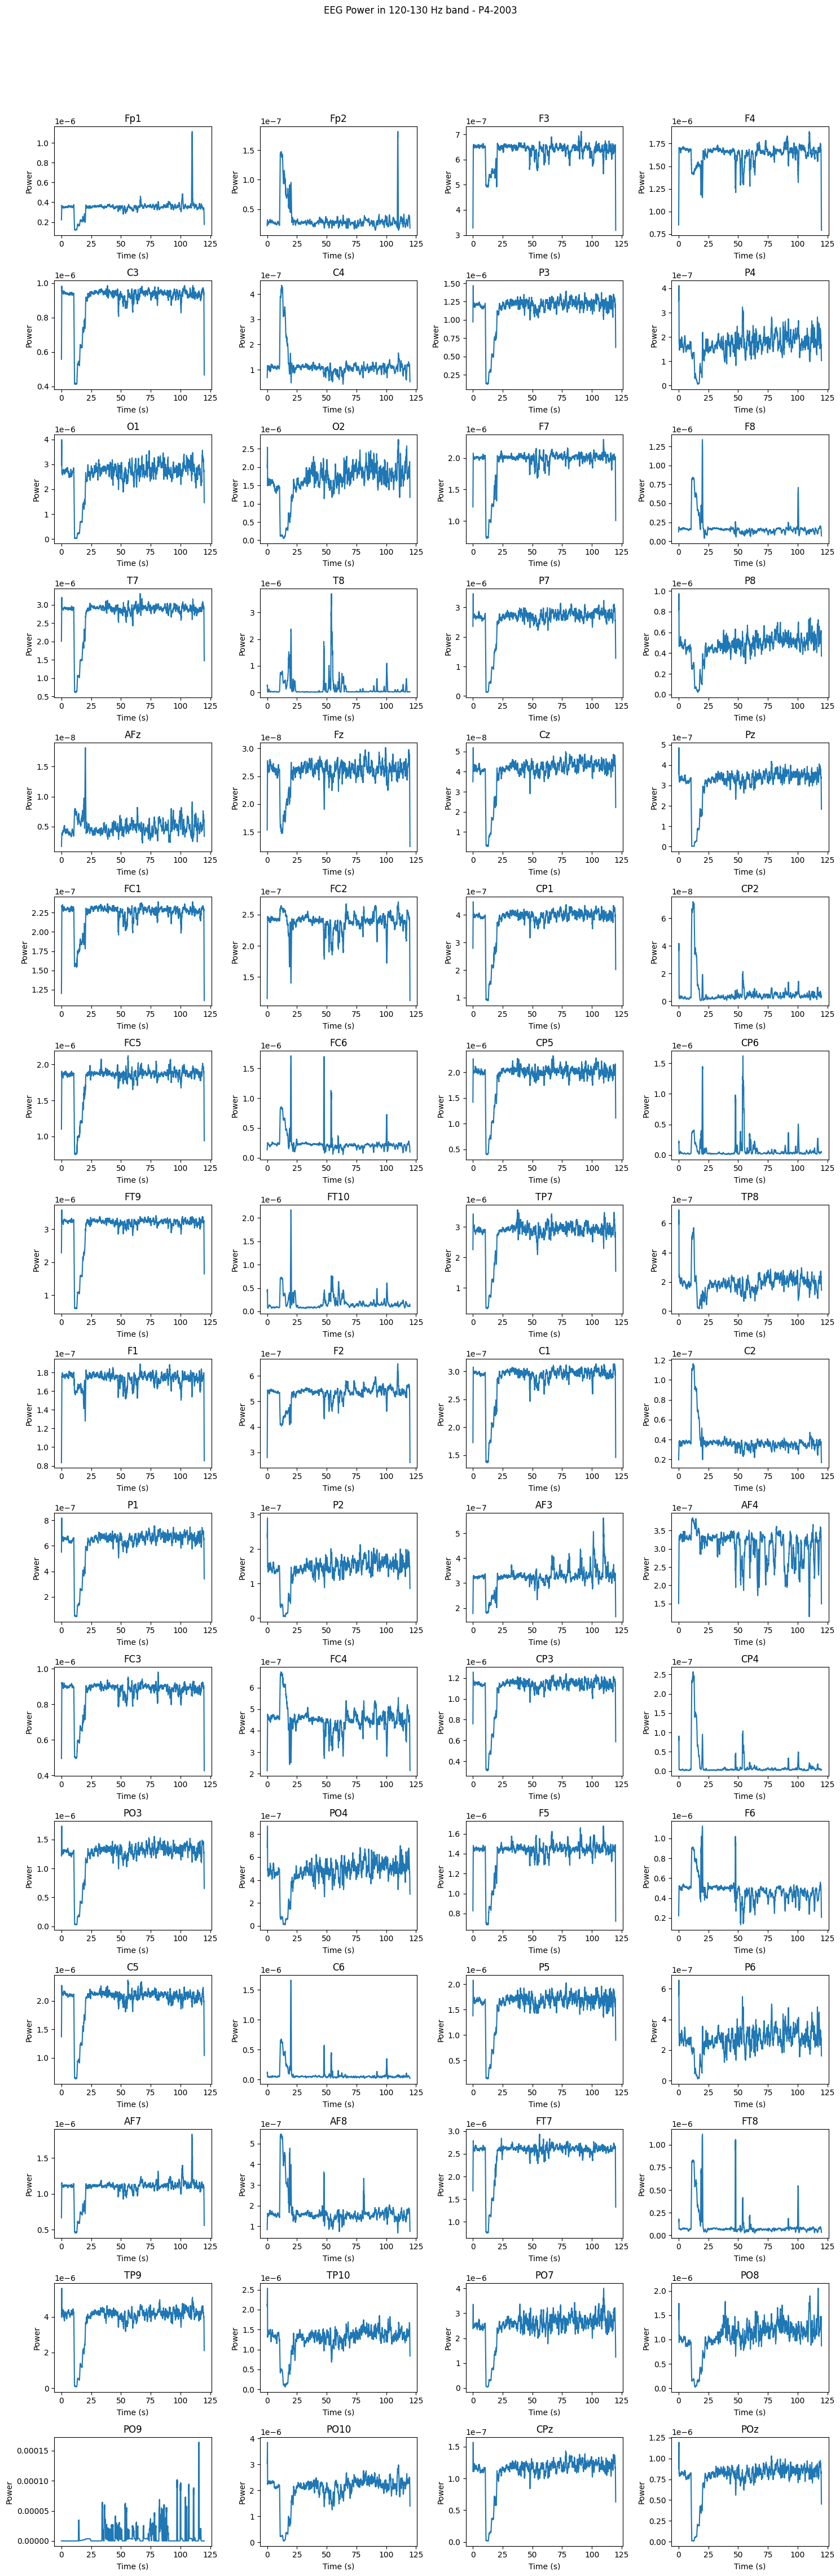


Processing P4-2004...


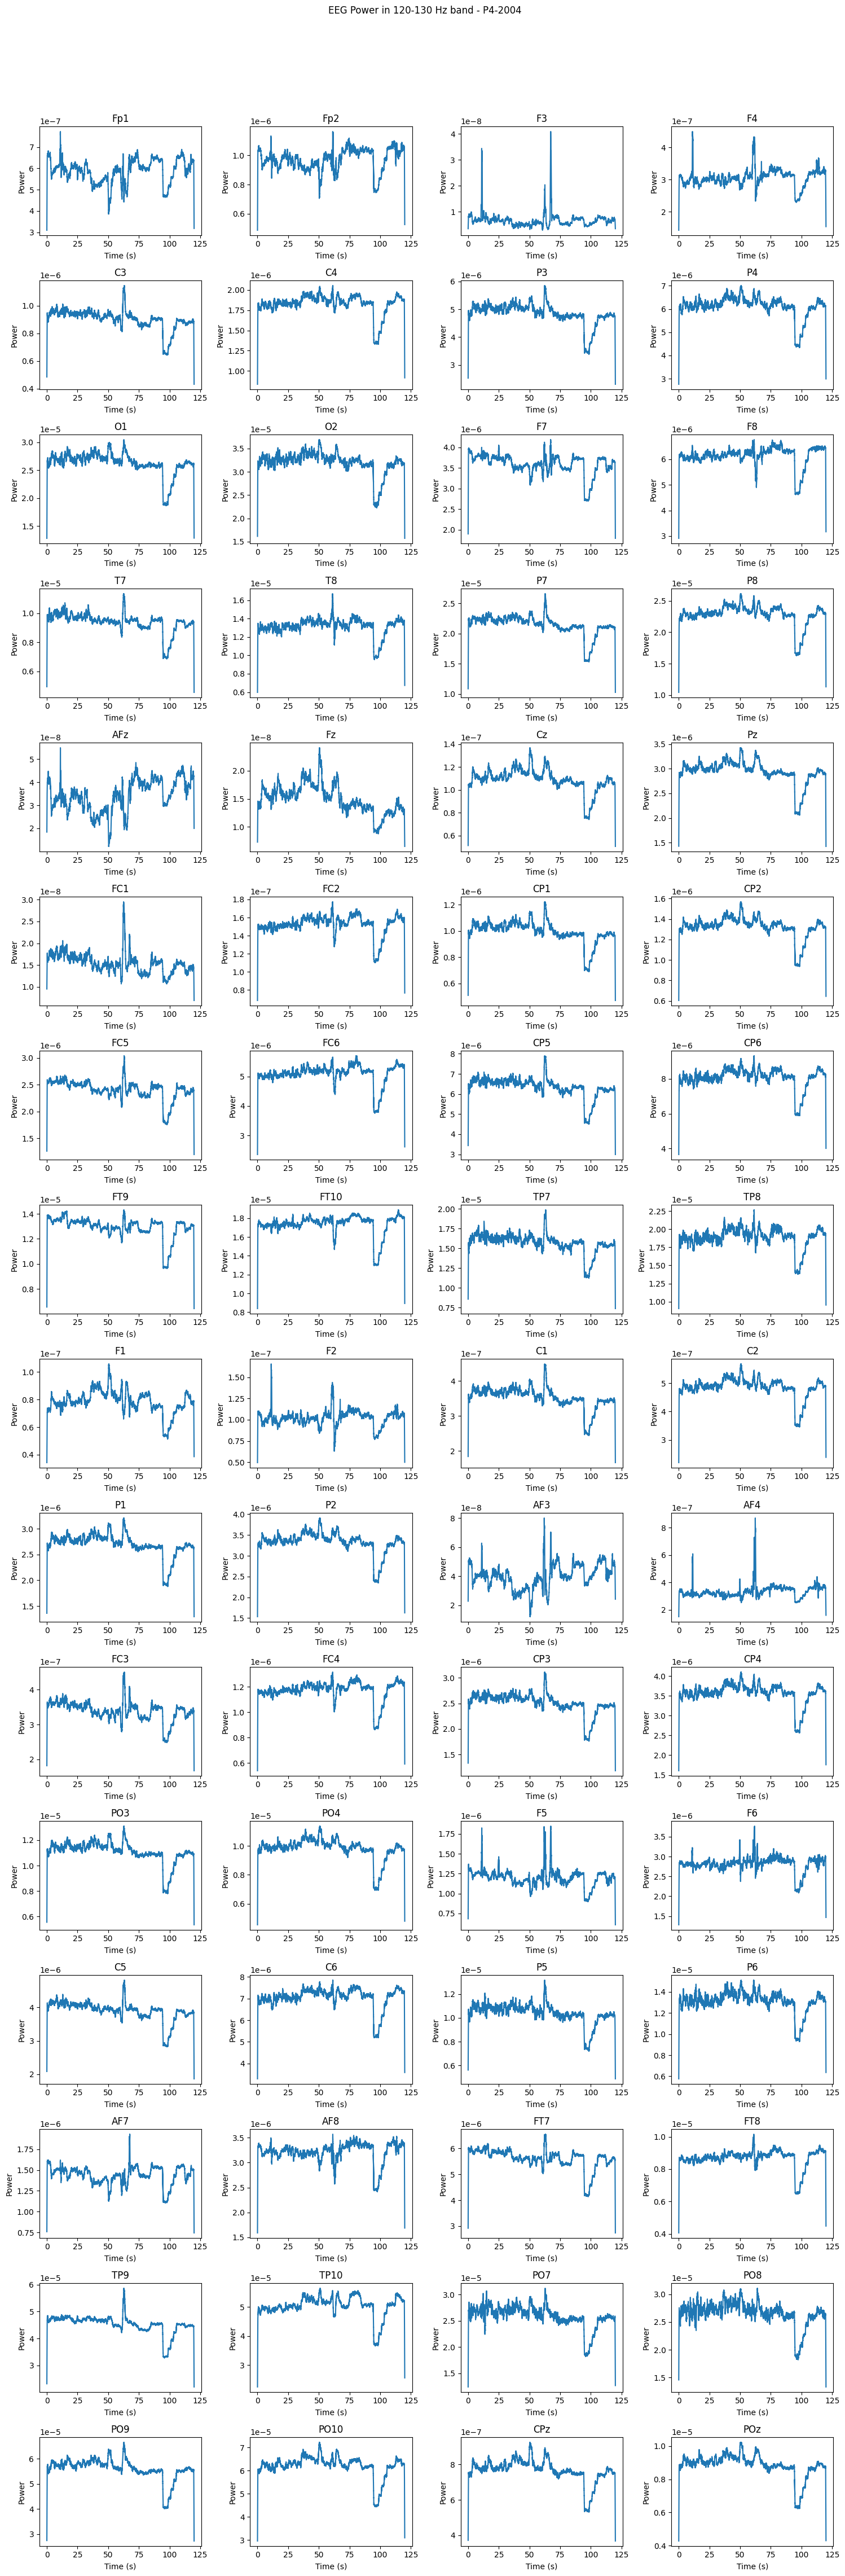


Processing P4-2005...


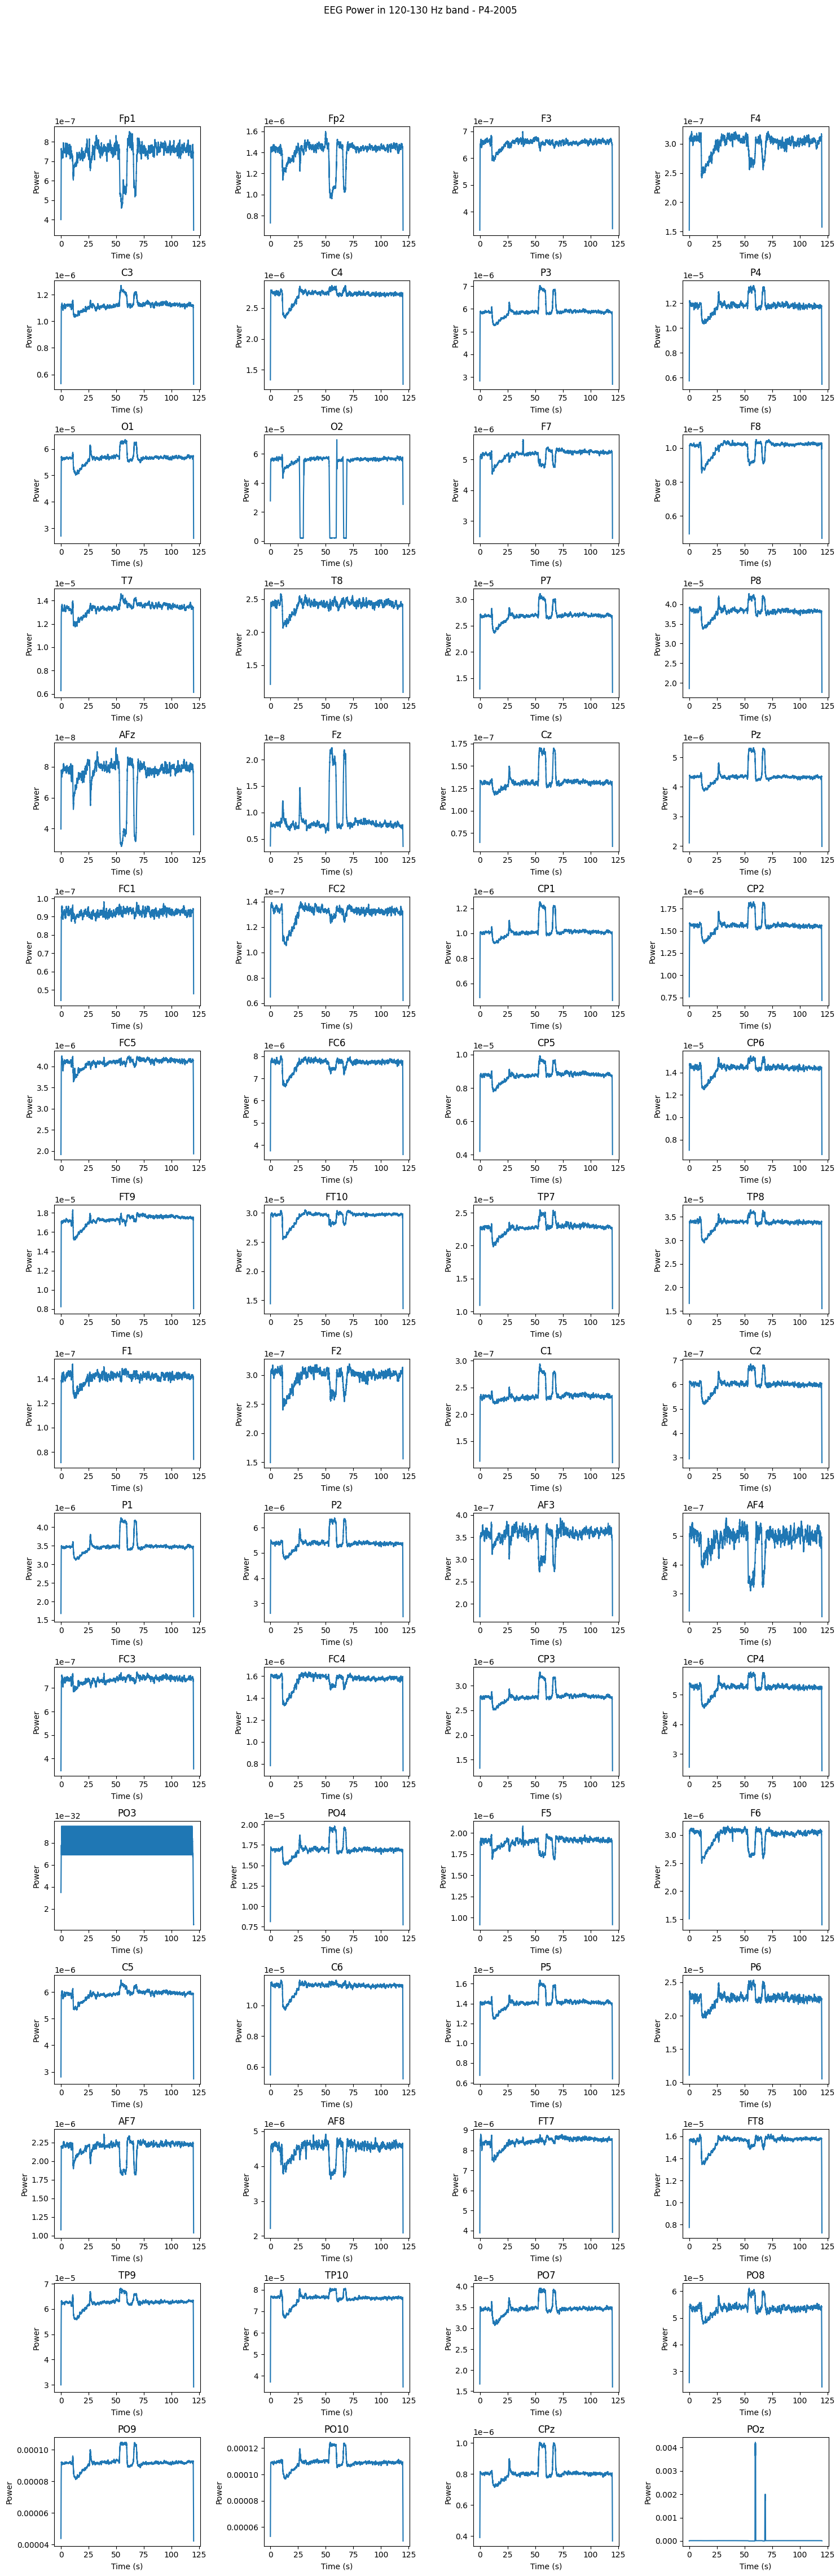


Processing P4-2007...


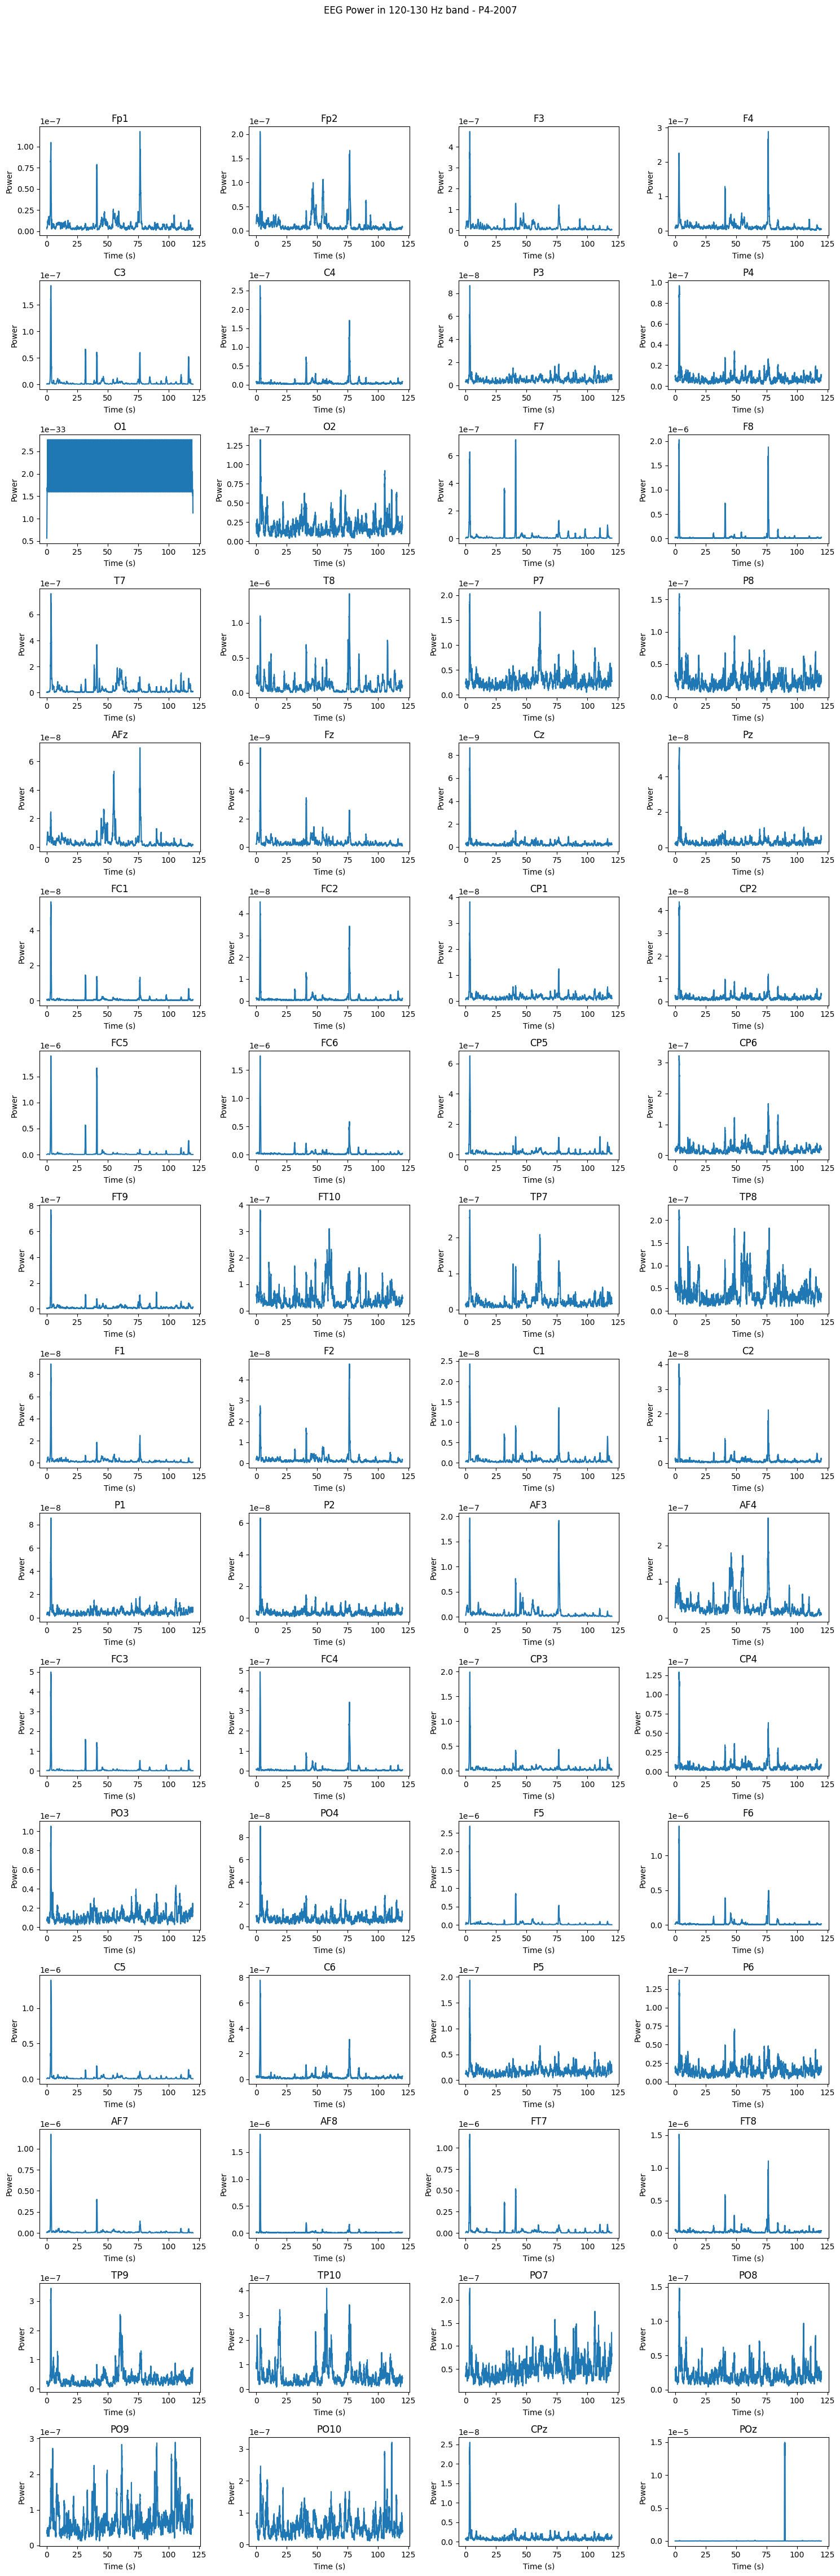


Processing P4-2008...


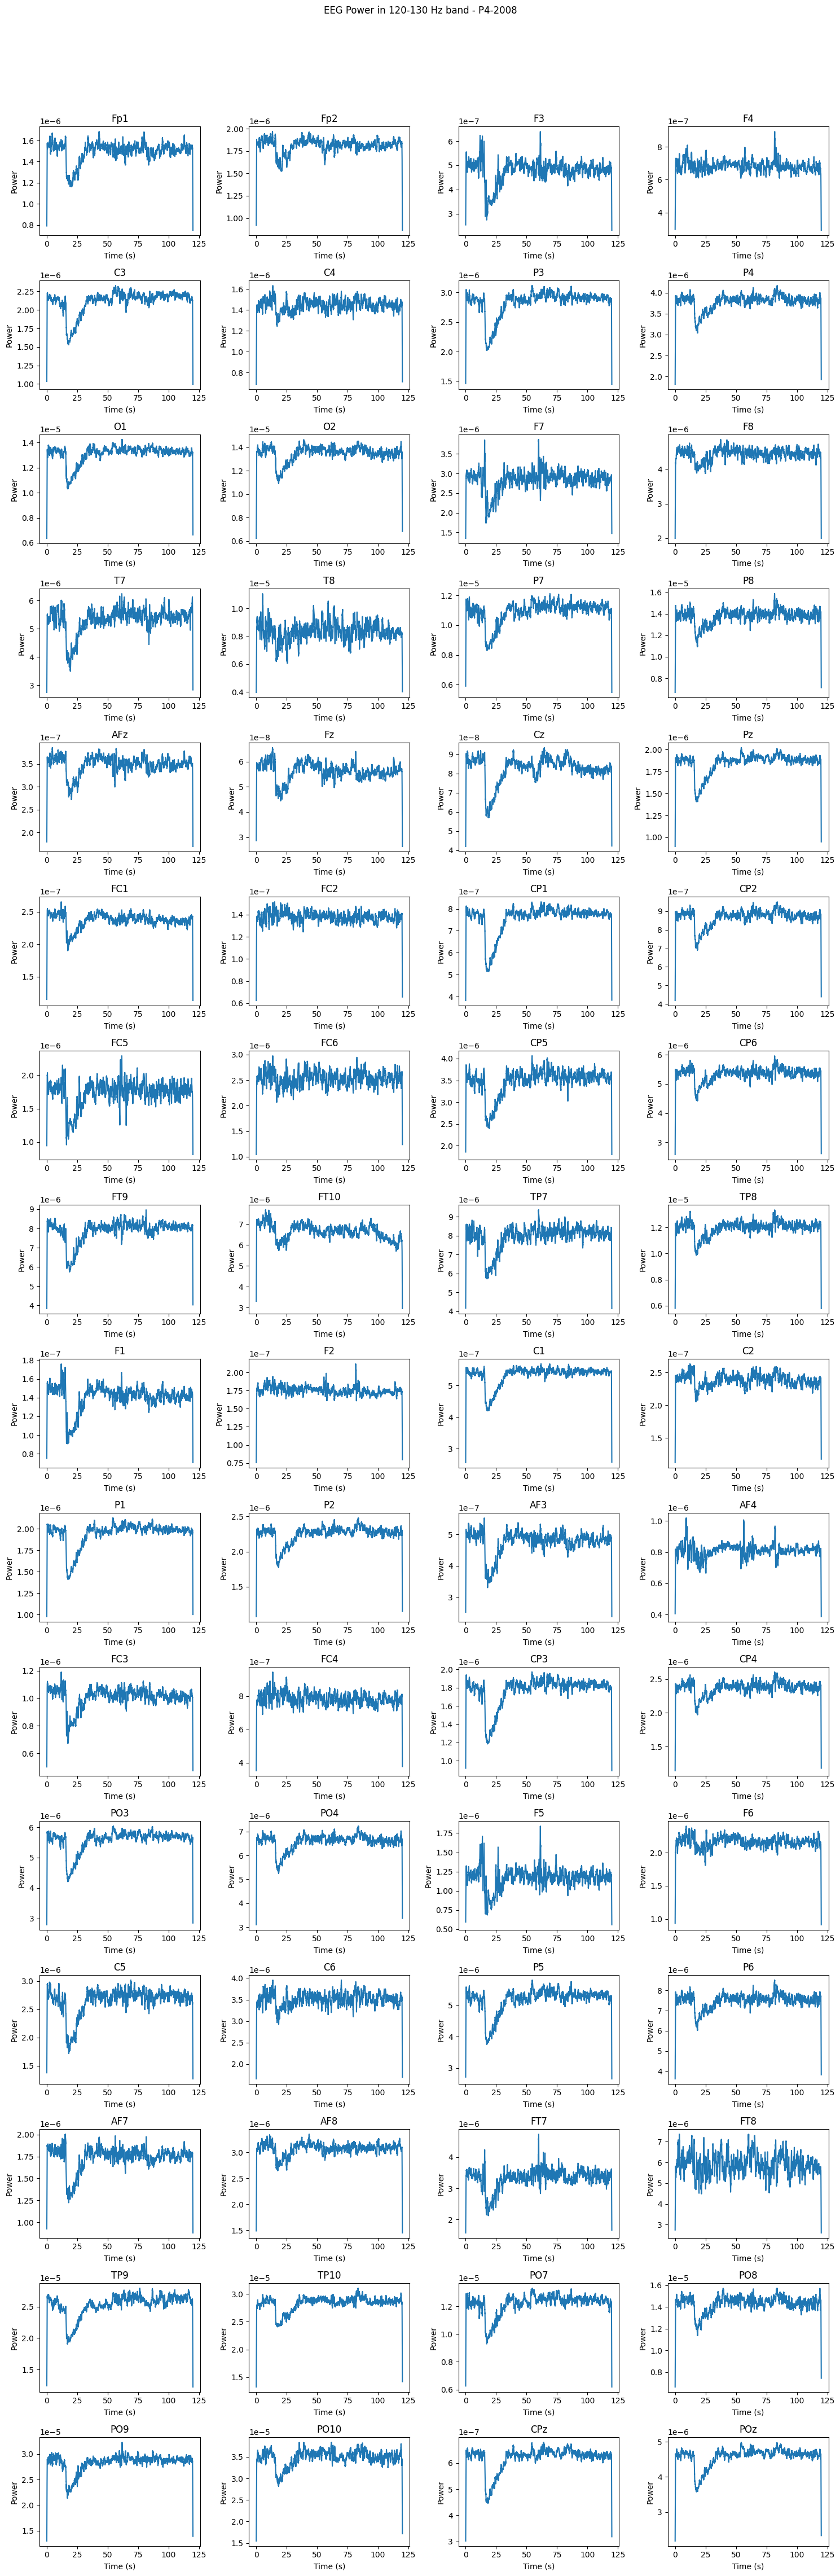


Processing P4-2009...


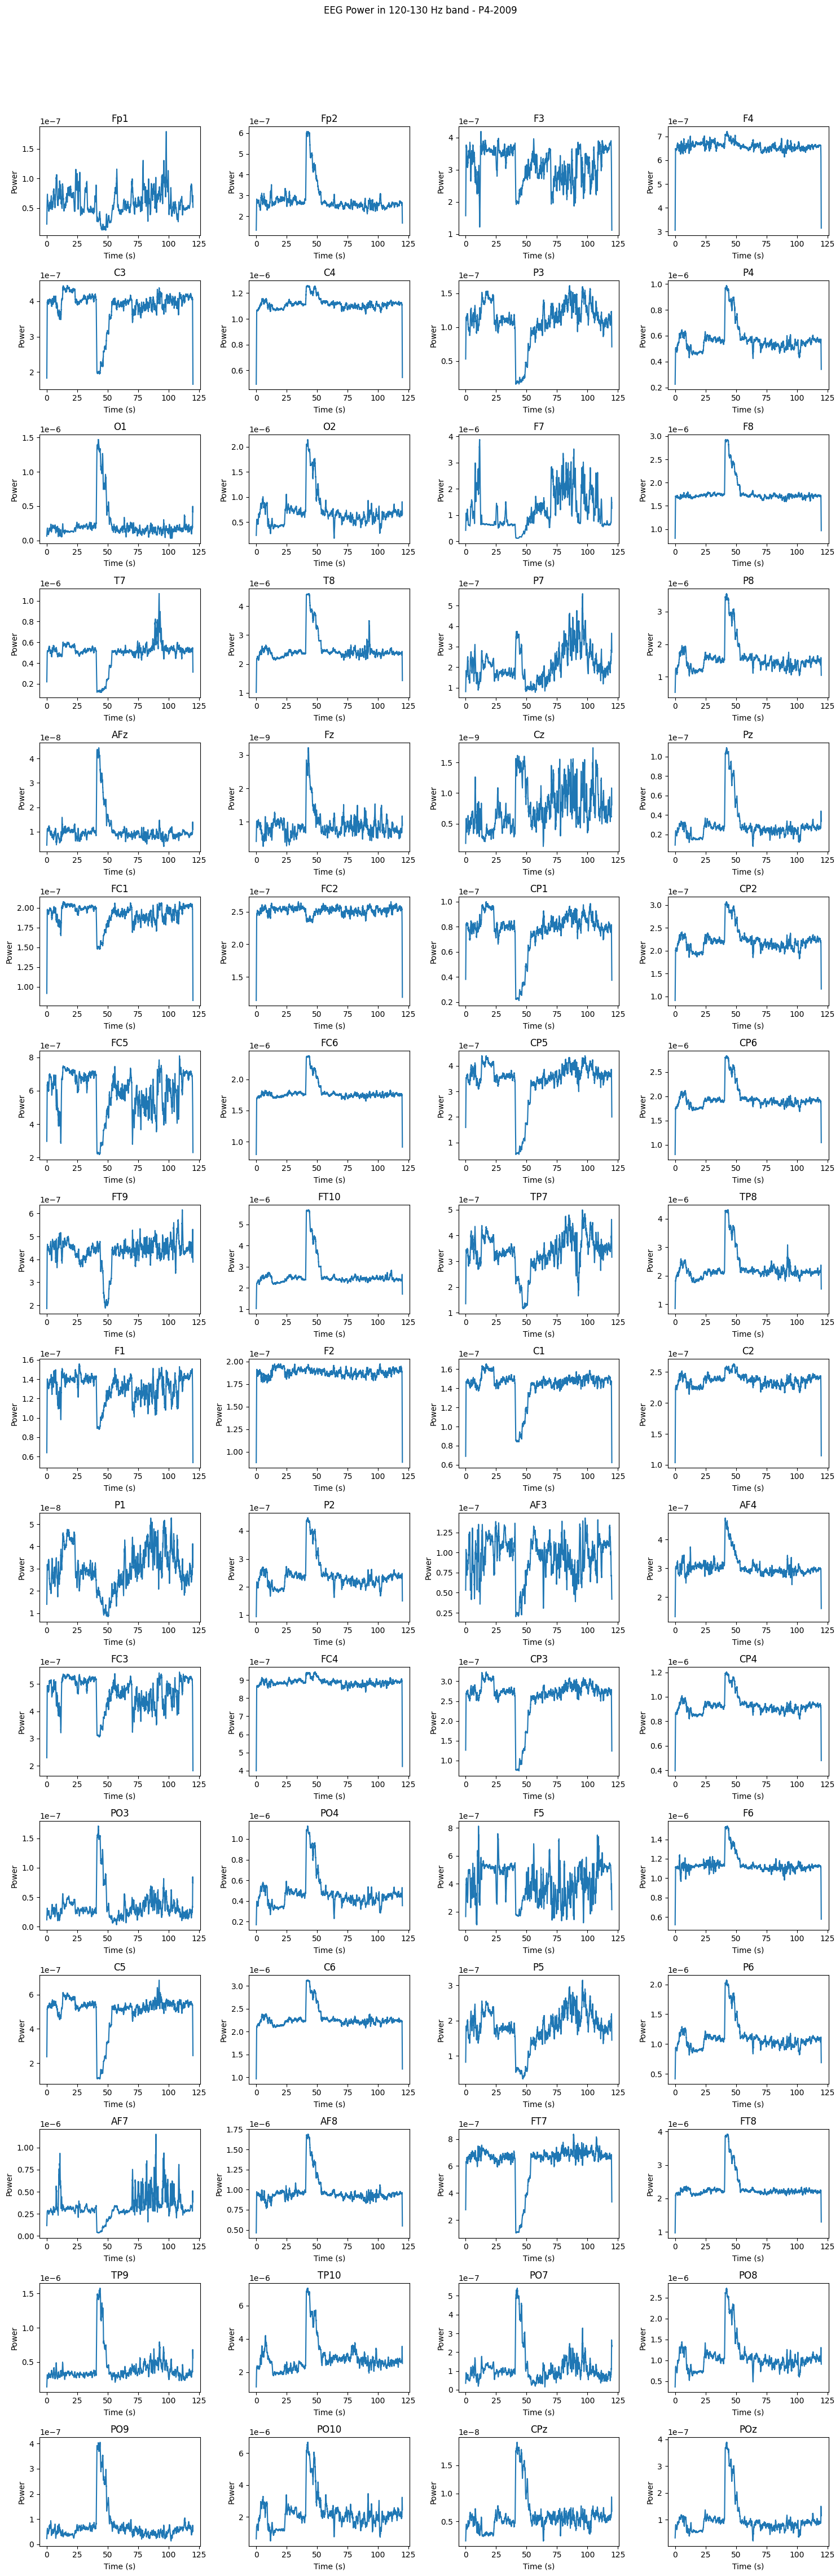

In [16]:
def plot_power_grid(sub_ids, block, dataDir_server):
    for sub_id in sub_ids:
        print(f"\nProcessing {sub_id}...")
        eeglab_file_path = os.path.join(
            dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set'
        )
        if not os.path.exists(eeglab_file_path):
            print(f"Skipping {sub_id}, file not found.")
            continue

        eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
        if sub_id == 'P4-2007':
            freq_low, freq_high = 110, 120
        else:
            freq_low, freq_high = 120, 130

        eeg_channel_names = eeg_raw.ch_names
        n_channels = len(eeg_channel_names)
        n_cols = 4
        n_rows = int(np.ceil(n_channels / n_cols))

        plt.figure(figsize=(15, n_rows * 3))
        for i, ch in enumerate(eeg_channel_names):
            try:
                eeg_power, time_axis = compute_eeg_power(
                    eeg_raw, freq_low, freq_high, channel=ch,
                )
            except Exception as e:
                print(f"Error processing {ch}: {e}")
                continue
            plt.subplot(n_rows, n_cols, i + 1)
            plt.plot(time_axis, eeg_power)
            plt.title(ch)
            plt.xlabel('Time (s)')
            plt.ylabel('Power')

        plt.suptitle(f"EEG Power in 120-130 Hz band - {sub_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009']
block = 'treadmill' # 'baseline', 'treadmill'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"
plot_power_grid(sub_ids, block, dataDir_server)